In [2]:
import os
import wfdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.io import loadmat

In [3]:
record = wfdb.rdrecord('CPSC/A6877')
# The signal data is in record.p_signal and the column names are in record.sig_name
df_ecg = pd.DataFrame(record.p_signal, columns=record.sig_name)
# Create a time column
df_ecg['Time (s)'] = np.arange(0, len(df_ecg) / record.fs, 1 / record.fs)

# To save to a CSV file
df_ecg.to_csv('ecg_data.csv', index=False)

# Or to display the first few rows
df_ecg.head()

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6,Time (s)
0,0.108,0.080,-0.028,-0.094,0.068,0.026,-0.047,0.200,0.124,0.078,0.060,-0.005,0.000
1,0.160,0.118,-0.043,-0.138,0.102,0.037,-0.064,0.272,0.170,0.110,0.087,0.009,0.002
2,0.143,0.105,-0.038,-0.124,0.091,0.034,-0.058,0.233,0.142,0.096,0.076,0.023,0.004
3,0.144,0.101,-0.043,-0.123,0.093,0.029,-0.063,0.230,0.140,0.094,0.073,0.038,0.006
4,0.146,0.102,-0.044,-0.123,0.095,0.029,-0.058,0.206,0.127,0.084,0.070,0.056,0.008


In [5]:
## checking if dataset is clean
## Load the dataset and conduct an initial analysis to look for common issues such as missing values, unusual outliers, or inconsistent data


df_ecg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18488 entries, 0 to 18487
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   I         18488 non-null  float64
 1   II        18488 non-null  float64
 2   III       18488 non-null  float64
 3   aVR       18488 non-null  float64
 4   aVL       18488 non-null  float64
 5   aVF       18488 non-null  float64
 6   V1        18488 non-null  float64
 7   V2        18488 non-null  float64
 8   V3        18488 non-null  float64
 9   V4        18488 non-null  float64
 10  V5        18488 non-null  float64
 11  V6        18488 non-null  float64
 12  Time (s)  18488 non-null  float64
dtypes: float64(13)
memory usage: 1.8 MB


In [6]:
## checking for missing values 
missing_values = df_ecg.isnull().sum()
print(missing_values)


I           0
II          0
III         0
aVR         0
aVL         0
aVF         0
V1          0
V2          0
V3          0
V4          0
V5          0
V6          0
Time (s)    0
dtype: int64


In [7]:
## Basic Statistical Analysis:

statistical_summary = df_ecg.describe()
print(statistical_summary)


                  I            II           III           aVR           aVL  \
count  18488.000000  1.848800e+04  18488.000000  18488.000000  18488.000000   
mean       0.000003  8.654262e-07     -0.000005     -0.000004      0.000001   
std        0.123623  1.178693e-01      0.059318      0.117084      0.076994   
min       -0.642000 -2.680000e-01     -0.428000     -1.065000     -0.512000   
25%       -0.049000 -4.700000e-02     -0.015000     -0.003000     -0.032000   
50%       -0.032000 -2.300000e-02      0.004000      0.029000     -0.019000   
75%       -0.002000  8.000000e-03      0.020000      0.047000      0.004000   
max        1.119000  1.083000e+00      0.409000      0.451000      0.713000   

                aVF            V1            V2            V3            V4  \
count  18488.000000  18488.000000  1.848800e+04  1.848800e+04  18488.000000   
mean      -0.000003     -0.000001  1.622674e-07  1.081783e-07     -0.000003   
std        0.069894      0.156624  3.531948e-01  3.

I           2288
II          1967
III         1981
aVR         1967
aVL         2111
aVF         2020
V1          1916
V2          2266
V3          2647
V4          2903
V5          2308
V6          5199
Time (s)       0
dtype: int64


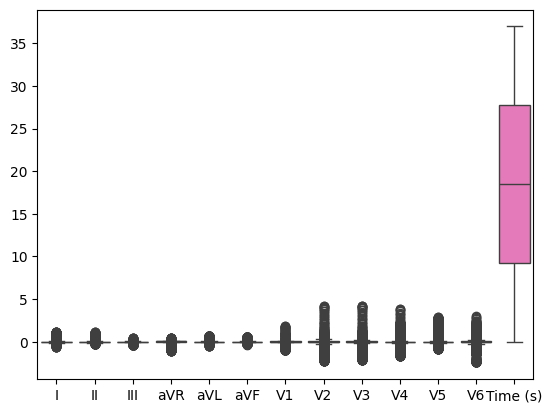

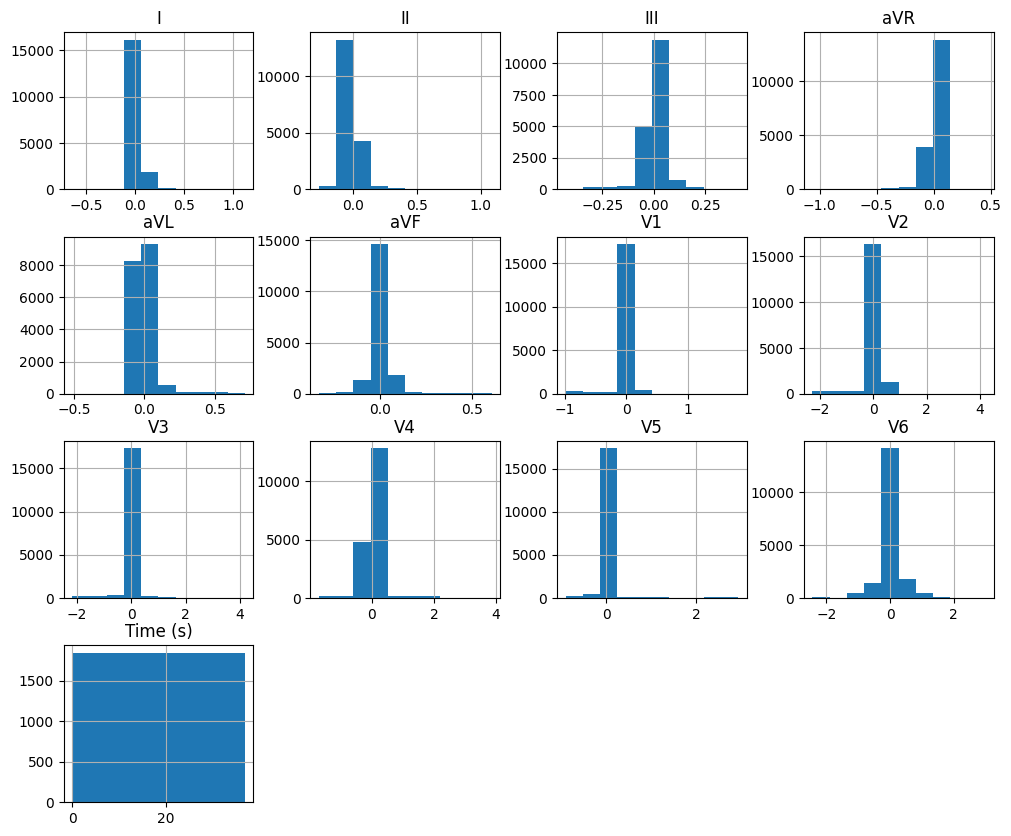

In [10]:
## Analyzing outliers

# Assuming df_ecg is your DataFrame
# Descriptive statistics

# IQR Method
Q1 = df_ecg.quantile(0.25)
Q3 = df_ecg.quantile(0.75)
IQR = Q3 - Q1
print(((df_ecg < (Q1 - 1.5 * IQR)) | (df_ecg > (Q3 + 1.5 * IQR))).sum())

# Box Plot
sns.boxplot(data=df_ecg)
plt.show()

# Histogram
df_ecg.hist(figsize=(12, 10))
plt.show()


In [12]:

### Noise enhancement 
"""
1. Working with the MIT-BIH test database
2. Analyze the Noise Characteristics (Baseline Drift, Muscle Artifact and Power Frequency 
"""

# Assuming 'noise_files' is a list of tuples containing the file paths and the noise type
# Example: [('118e_6', 'BD'), ('119e_6', 'MA'), ...]
noise_files = [('mit-bih-noise-stress-test-database-1.0.0/118e_6', 'BD'), ('mit-bih-noise-stress-test-database-1.0.0/119e_6', 'MA'), ('mit-bih-noise-stress-test-database-1.0.0/119e_6', 'PF')]  # Replace with actual paths and types

# Initialize empty lists to store the noise arrays
BD_noise_list = []
MA_noise_list = []
PF_noise_list = []

# Loop through the noise files and process them
for file_path, noise_type in noise_files:
    record = wfdb.rdrecord(file_path)
    noise_array = record.p_signal.flatten()  # Flatten in case of multi-dimensional array

    # Append the noise array to the corresponding list
    if noise_type == 'BD':
        BD_noise_list.append(noise_array)
    elif noise_type == 'MA':
        MA_noise_list.append(noise_array)
    elif noise_type == 'PF':
        PF_noise_list.append(noise_array)
    # Add more conditions if there are more noise types

# Convert lists to numpy arrays
BD_noise = np.concatenate(BD_noise_list)
MA_noise = np.concatenate(MA_noise_list)
PF_noise = np.concatenate(PF_noise_list)

print(BD_noise)
print(MA_noise)
print(PF_noise)


[ -5.955  -5.635  -5.955 ... -15.55    2.24  -20.665]
[ -6.115  -5.59   -6.115 ... -11.44    2.02  -16.555]
[ -6.115  -5.59   -6.115 ... -11.44    2.02  -16.555]


In [37]:


### Extracting a clean separate ECG signal dataset and then converting them into numpy array

# Path to your 'NSR' folder
nsr_folder_path = 'ECG signals (1000 fragments)/MLII/NSR'

# Get a list of all .mat files in the 'NSR' folder
nsr_files = [f for f in os.listdir(nsr_folder_path) if f.endswith('.mat')]

# Initialize an empty list to hold all the ECG signals from the NSR folder
pure_ecg_signals = []

# Define the gain factor for conversion to millivolts
gain_factor = 200  # adu/mV

# Load each .mat file and append its contents to the list
for mat_file in nsr_files:
    mat_data = loadmat(os.path.join(nsr_folder_path, mat_file))
    
    # The key under which the ECG data is stored may vary, you need to check the .mat file structure
    ecg_signal = mat_data['val'][0]  # Assuming 'val' is the key and taking the first channel if multiple

    # Convert the ADC values to millivolts by dividing by the gain factor
    ecg_signal_mv = ecg_signal / gain_factor
    
    # Append the millivolt signal to the list
    pure_ecg_signals.append(ecg_signal_mv)

# Convert the list of ECG signals to a numpy array
pure_ecg_signal_array = np.array(pure_ecg_signals)

# Print the first signal as an example
# print(pure_ecg_signal_array[0])
print(pure_ecg_signal_array)



[[4.765 4.755 4.745 ... 4.7   4.715 4.72 ]
 [4.575 4.635 4.67  ... 4.825 4.815 4.81 ]
 [4.945 4.92  4.905 ... 4.745 4.745 4.76 ]
 ...
 [4.875 4.88  4.875 ... 4.98  4.965 4.95 ]
 [5.225 5.215 5.215 ... 4.92  4.91  4.895]
 [4.605 4.61  4.605 ... 4.98  4.975 4.975]]


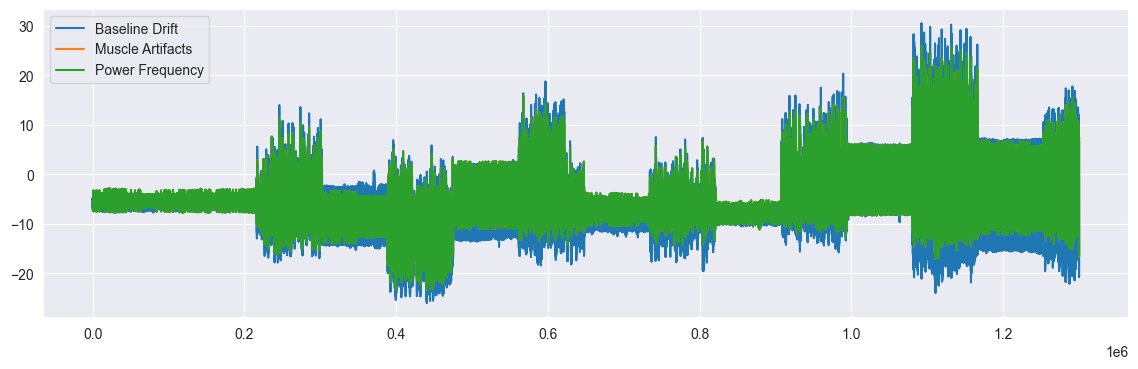

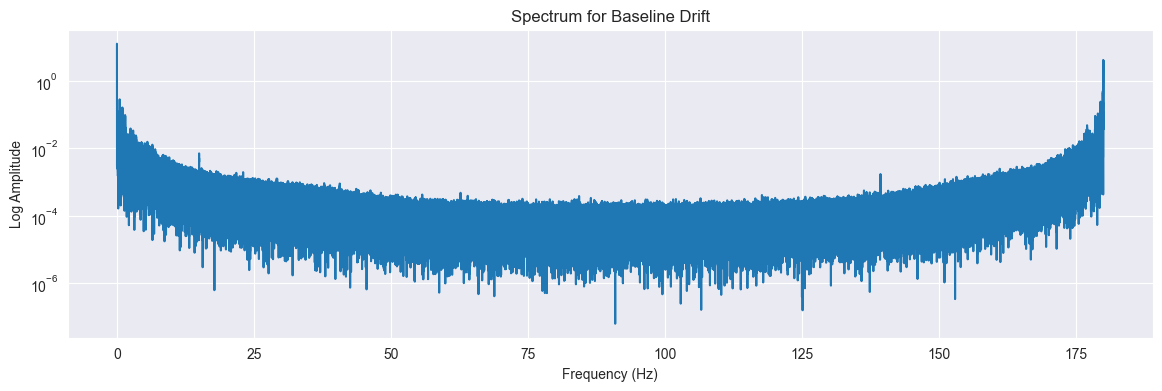

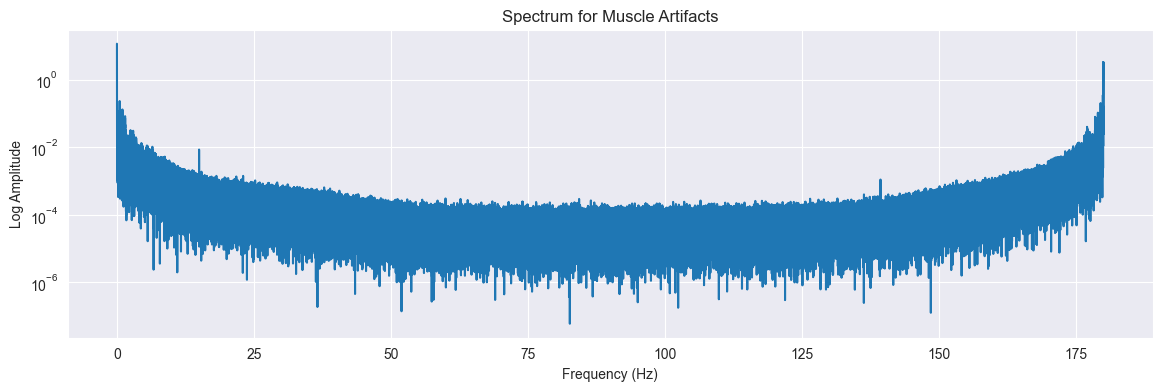

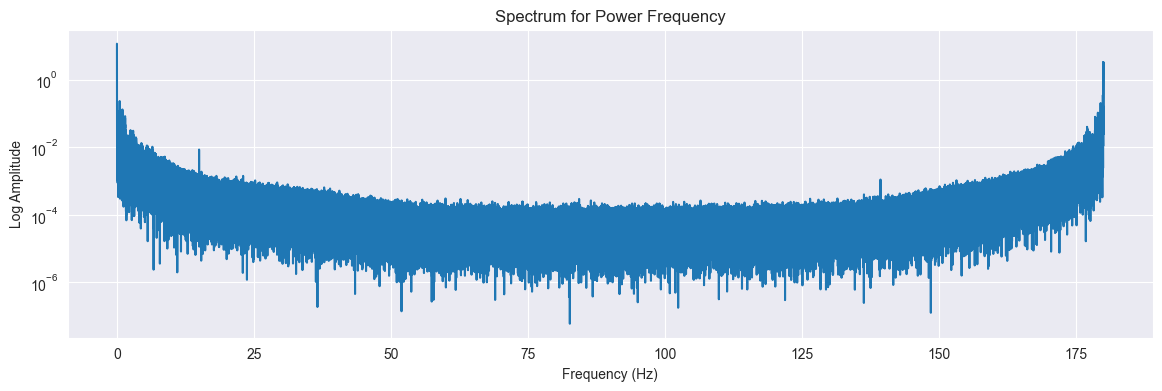

Mean of BD noise: -6.299286861538461
Variance of BD noise: 41.975329592779694

Mean of MA noise: -5.731486376923081
Variance of MA noise: 26.431194580375948

Mean of PF noise: -5.731486376923081
Variance of PF noise: 26.431194580375948

Max amplitude of BD noise: 30.575
Max amplitude of MA noise: 25.965
Max amplitude of PF noise: 25.965

SNR for BD noise: -5.62116633796072 dB

SNR for MA noise: -4.230431778329235 mA

SNR for PF noise: -4.230431778329235 pF


In [42]:
## Visualizing the types of noise

# Visual Inspection
plt.figure(figsize=(14, 4))
plt.plot(BD_noise, label='Baseline Drift')
plt.plot(MA_noise, label='Muscle Artifacts')
plt.plot(PF_noise, label='Power Frequency')
plt.legend()
plt.show()

# Spectral Analysis
def plot_spectrum(noise, title):
    # Compute the Fast Fourier Transform (FFT)
    n = len(noise)
    t = 1.0 / 360.0  # Assuming a sampling rate of 360 Hz
    yf = fft(noise)
    xf = fftfreq(n, t)[:n//2]

    plt.figure(figsize=(14, 4))
    # Use logarithmic scale if there are very small/large values
    plt.semilogy(xf, 2.0/n * np.abs(yf[0:n//2]))
    plt.title(f'Spectrum for {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Log Amplitude')
    plt.grid(True)  # Add grid for better readability
    plt.show()


plot_spectrum(BD_noise, 'Baseline Drift')
plot_spectrum(MA_noise, 'Muscle Artifacts')
plot_spectrum(PF_noise, 'Power Frequency')

# Statistical Analysis
print(f"Mean of BD noise: {np.mean(BD_noise)}")
print(f"Variance of BD noise: {np.var(BD_noise)}")
print()

print(f"Mean of MA noise: {np.mean(MA_noise)}")
print(f"Variance of MA noise: {np.var(MA_noise)}")
print()

print(f"Mean of PF noise: {np.mean(PF_noise)}")
print(f"Variance of PF noise: {np.var(PF_noise)}")
print()


# Amplitude Analysis
print(f"Max amplitude of BD noise: {np.max(np.abs(BD_noise))}")
print(f"Max amplitude of MA noise: {np.max(np.abs(MA_noise))}")
print(f"Max amplitude of PF noise: {np.max(np.abs(PF_noise))}")
print()


# SNR Calculation (example, assuming you have a pure_ecg_signal array)
signal_power = np.mean(pure_ecg_signal_array**2)
bd_noise_power = np.mean(BD_noise**2)
snr_bd = 10 * np.log10(signal_power / bd_noise_power)
print(f"SNR for BD noise: {snr_bd} dB")
print()


signal_power = np.mean(pure_ecg_signal_array**2)
ma_noise_power = np.mean(MA_noise**2)
snr_ma = 10 * np.log10(signal_power / ma_noise_power)
print(f"SNR for MA noise: {snr_ma} mA")
print()


signal_power = np.mean(pure_ecg_signal_array**2)
pf_noise_power = np.mean(PF_noise**2)
snr_pf = 10 * np.log10(signal_power / pf_noise_power)
print(f"SNR for PF noise: {snr_pf} pF")